In [16]:
import random
from configs import CFG1
from generation_utils import get_random_color_pair, split_sentence
from generators import create_image

# データ準備

In [18]:
from pathlib import Path
import pandas as pd

all_messages = pd.read_csv("texts/messages.csv")
# messages = all_messages.groupby("char").first()  # train
messages = all_messages.groupby("char").first()  # validation
names = pd.read_csv("texts/names.csv")

bgimage_paths = list(Path("bgimages").rglob(pattern="*.png"))
fgimage_paths = list(Path("fgimages").rglob(pattern="*.png"))
messages.shape, names.shape, len(bgimage_paths), len(fgimage_paths)

((5254, 4), (6480, 5), 976, 354)

In [19]:
import glob
message_fonts = glob.glob("fonts/fonts_message/*")
ruby_fonts = glob.glob("fonts/fonts_message/*")
len(message_fonts), len(ruby_fonts)

(11, 11)

In [20]:
def generate_standard():
    cfg = CFG1()

    # 名前
    if random.random() < 0.5:
        name, name_ruby_hira, name_ruby_kata = names.sample(1)[["text", "text_ruby_hiragana", "text_ruby_katakana"]].values[0]
        cfg.name_text = random.choice([name, name_ruby_hira, name_ruby_kata])
        cfg.name_font_path = random.choice(message_fonts)

    # メッセージ
    text, text_ruby_hira, text_ruby_kata = messages.sample(1)[["text", "text_ruby_hiragana", "text_ruby_katakana"]].values[0]
    cfg.text = random.choice([text, text_ruby_hira, text_ruby_kata])
    cfg.msg_font_path = random.choice(message_fonts)
    
    # 選択肢
    n_options = random.choice([0, 0, 0, 0, 0, 1, 1, 1, 2, 2])
    if n_options == 1:
        cfg.optionbox_tl_list = [(230, (250+435)//2)]
        cfg.optionbox_br_list = [(1680, (385+570)//2)]
    elif n_options == 0:
        cfg.optionbox_tl_list = []
        cfg.optionbox_br_list = []
    option_texts = []
    for _ in range(n_options):
        op_text, op_text_ruby_hira, op_text_ruby_kata = messages.sample(1)[["text", "text_ruby_hiragana", "text_ruby_katakana"]].values[0]
        op_target_text = random.choice([op_text, op_text_ruby_hira, op_text_ruby_kata])
        op_target_text = random.choice(split_sentence(op_target_text)) # messagesのtextから選択肢には1文だけ取り出して使う
        option_texts.append(op_target_text)
    cfg.option_texts = option_texts
    cfg.option_font_path = random.choice(message_fonts)
    cfg.option_ruby_font_path = random.choice(ruby_fonts)

    # 背景画像
    bg_path = random.choice(bgimage_paths)
    cfg.bg_path = bg_path

    # 人物などの画像
    n_fg_images = random.choice([0, 1, 2])
    if n_fg_images == 1:
        cfg.fg_tl_list = [(500, 100)]
    elif n_fg_images == 2:
        cfg.fg_tl_list = [(200, 100), (1000, 100)]

    cfg.fg_pathlist = random.sample(fgimage_paths, n_fg_images)

    output = create_image(cfg)
    gt_obj = {
        "gt_parse":{"messages":[output.text], "names":[output.name_text], "options":output.option_texts},
        "meta":{"version":"0.1.0", "split":"train", "image_size":{"width":cfg.W, "height":cfg.H}}
        }
    return output.image, gt_obj

In [21]:
from random import randint, uniform, choice

def generate_random():
    cfg = CFG1()

    # 名前
    if random.random() < .75:
        name, name_ruby_hira, name_ruby_kata = names.sample(1)[["text", "text_ruby_hiragana", "text_ruby_katakana"]].values[0]
        cfg.name_text = choice([name, name_ruby_hira, name_ruby_kata])
        cfg.name_font_path = choice(message_fonts)
        cfg.name_font_color, cfg.namebox_hex = get_random_color_pair()
        cfg.namebox_alpha = randint(80, 255)
    minheight = cfg.namebox_minheight()
    is_namebox_above = random.random() < 0.5  # nameboxをmsgboxの上に配置するか下に配置するか
    cfg.namebox_tl = (
        choice([randint(10, 100), randint(540, 700)]),
        randint(600, 750) if is_namebox_above else randint(1080-(minheight+100), 1080-(minheight+10))
        )
    cfg.namebox_br = (cfg.namebox_tl[0] + randint(400, 800), cfg.namebox_tl[1] + randint(minheight, minheight+10))

    # メッセージ
    text, text_ruby_hira, text_ruby_kata = messages.sample(1)[["text", "text_ruby_hiragana", "text_ruby_katakana"]].values[0]
    cfg.text = choice([text, text_ruby_hira, text_ruby_kata])
    cfg.msg_font_path = choice(message_fonts)
    cfg.msg_font_color, cfg.msgbox_hex = get_random_color_pair()
    cfg.msgbox_alpha = randint(160, 255)
    cfg.msg_font_size = randint(36, 55)
    cfg.msg_ruby_font_size = randint(16, 24)
    cfg.msgbox_tl = (
        randint(20, 300),
        randint(cfg.namebox_br[1]-cfg.msg_margin.top, cfg.namebox_br[1]-cfg.msg_margin.top+50) if is_namebox_above else randint(540, 700)
        )
    cfg.msgbox_br = (
        randint(1600, 1880),
        randint(1000, 1055) if is_namebox_above else randint(cfg.namebox_tl[1]-30, cfg.namebox_tl[1]+10)
    )
    # 選択肢
    n_options = random.choice([0, 0, 0, 0, 0, 1, 1, 1, 2, 2])
    optionbox_centor = randint(800, 1100)
    optionbox_halfwidth = randint(500, 700)
    optionbox_height = randint(cfg.optionbox_minheight(), cfg.optionbox_minheight()+10)
    optionbox_top = randint(120, 250)
    cfg.optionbox_tl_list = [
        (optionbox_centor-optionbox_halfwidth, optionbox_top),
        (optionbox_centor-optionbox_halfwidth, optionbox_top + optionbox_height+ randint(10, 50))
    ]
    cfg.optionbox_br_list = [
        (optionbox_centor+optionbox_halfwidth, cfg.optionbox_tl_list[0][1]+optionbox_height),
        (optionbox_centor+optionbox_halfwidth, cfg.optionbox_tl_list[1][1]+optionbox_height)
    ]
    if n_options == 1:
        cfg.optionbox_tl_list = [(optionbox_centor-optionbox_halfwidth, (cfg.optionbox_tl_list[0][1]+cfg.optionbox_tl_list[1][1])//2)]
        cfg.optionbox_br_list = [(optionbox_centor+optionbox_halfwidth, (cfg.optionbox_br_list[0][1]+cfg.optionbox_br_list[1][1])//2)]
    elif n_options == 0:
        cfg.optionbox_tl_list = []
        cfg.optionbox_br_list = []
    option_texts = []
    for _ in range(n_options):
        op_text, op_text_ruby_hira, op_text_ruby_kata = messages.sample(1)[["text", "text_ruby_hiragana", "text_ruby_katakana"]].values[0]
        op_target_text = random.choice([op_text, op_text_ruby_hira, op_text_ruby_kata])
        op_target_text = random.choice(split_sentence(op_target_text)) # messagesのtextから選択肢には1文だけ取り出して使う
        option_texts.append(op_target_text)
    cfg.option_texts = option_texts
    cfg.option_font_path = random.choice(message_fonts)
    cfg.option_ruby_font_path = random.choice(ruby_fonts)
    cfg.option_font_color, cfg.optionbox_hex = get_random_color_pair()
    cfg.optionbox_alpha = random.randint(160, 255)
    cfg.option_font_size = random.randint(36, 60)
    cfg.option_ruby_font_size = random.randint(16, 24)

    # 背景画像
    bg_path = random.choice(bgimage_paths)
    cfg.bg_path = bg_path

    # 人物などの画像
    n_fg_images = random.choice([0, 1, 2])
    if n_fg_images == 1:
        cfg.fg_tl_list = [(500, 100)]
    elif n_fg_images == 2:
        cfg.fg_tl_list = [(200, 100), (1000, 100)]

    cfg.fg_pathlist = random.sample(fgimage_paths, n_fg_images)

    output = create_image(cfg)
    gt_obj = {
        "gt_parse":{"messages":[output.text], "names":[output.name_text], "options":output.option_texts},
        "meta":{"version":"0.1.0", "split":"train", "image_size":{"width":cfg.W, "height":cfg.H}}
        }
    return output.image, gt_obj

In [24]:
import json
import datasets
from datasets import Dataset
images, gts = [], []
for i in range(1, 201):
    try:
        if i <=100:
            image, gt = generate_standard()
        else:
            image, gt = generate_random()
        output_image_path = f"output_images/{i:05d}.png"
        image.save(output_image_path)
        images.append(output_image_path)
        gts.append(gt)
    except Exception as e:
        print(i, e)

    if len(images) == 200:
        df = pd.DataFrame([[img, json.dumps(gt, ensure_ascii=False)] for img, gt in zip(images, gts)], columns=["image", "ground_truth"])
        ds = Dataset.from_pandas(df)
        ds = ds.cast_column("image", datasets.Image())
        ds.save_to_disk(f"output_datasets/dataset_{i}")
        images, gts = [], []

Saving the dataset (0/1 shards):   0%|          | 0/20 [00:00<?, ? examples/s]

In [12]:
# dss = []
# for i in range(200, 1801, 200):
#     dss.append(datasets.load_from_disk(f"output_datasets/dataset_{i}"))
# ds = datasets.concatenate_datasets(dss)
# ds.save_to_disk("output_datasets/dataset_random")

Saving the dataset (0/8 shards):   0%|          | 0/1800 [00:00<?, ? examples/s]

In [13]:
ds = Dataset.load_from_disk(f"output_datasets/dataset_random")
ds

Dataset({
    features: ['image', 'ground_truth'],
    num_rows: 1800
})

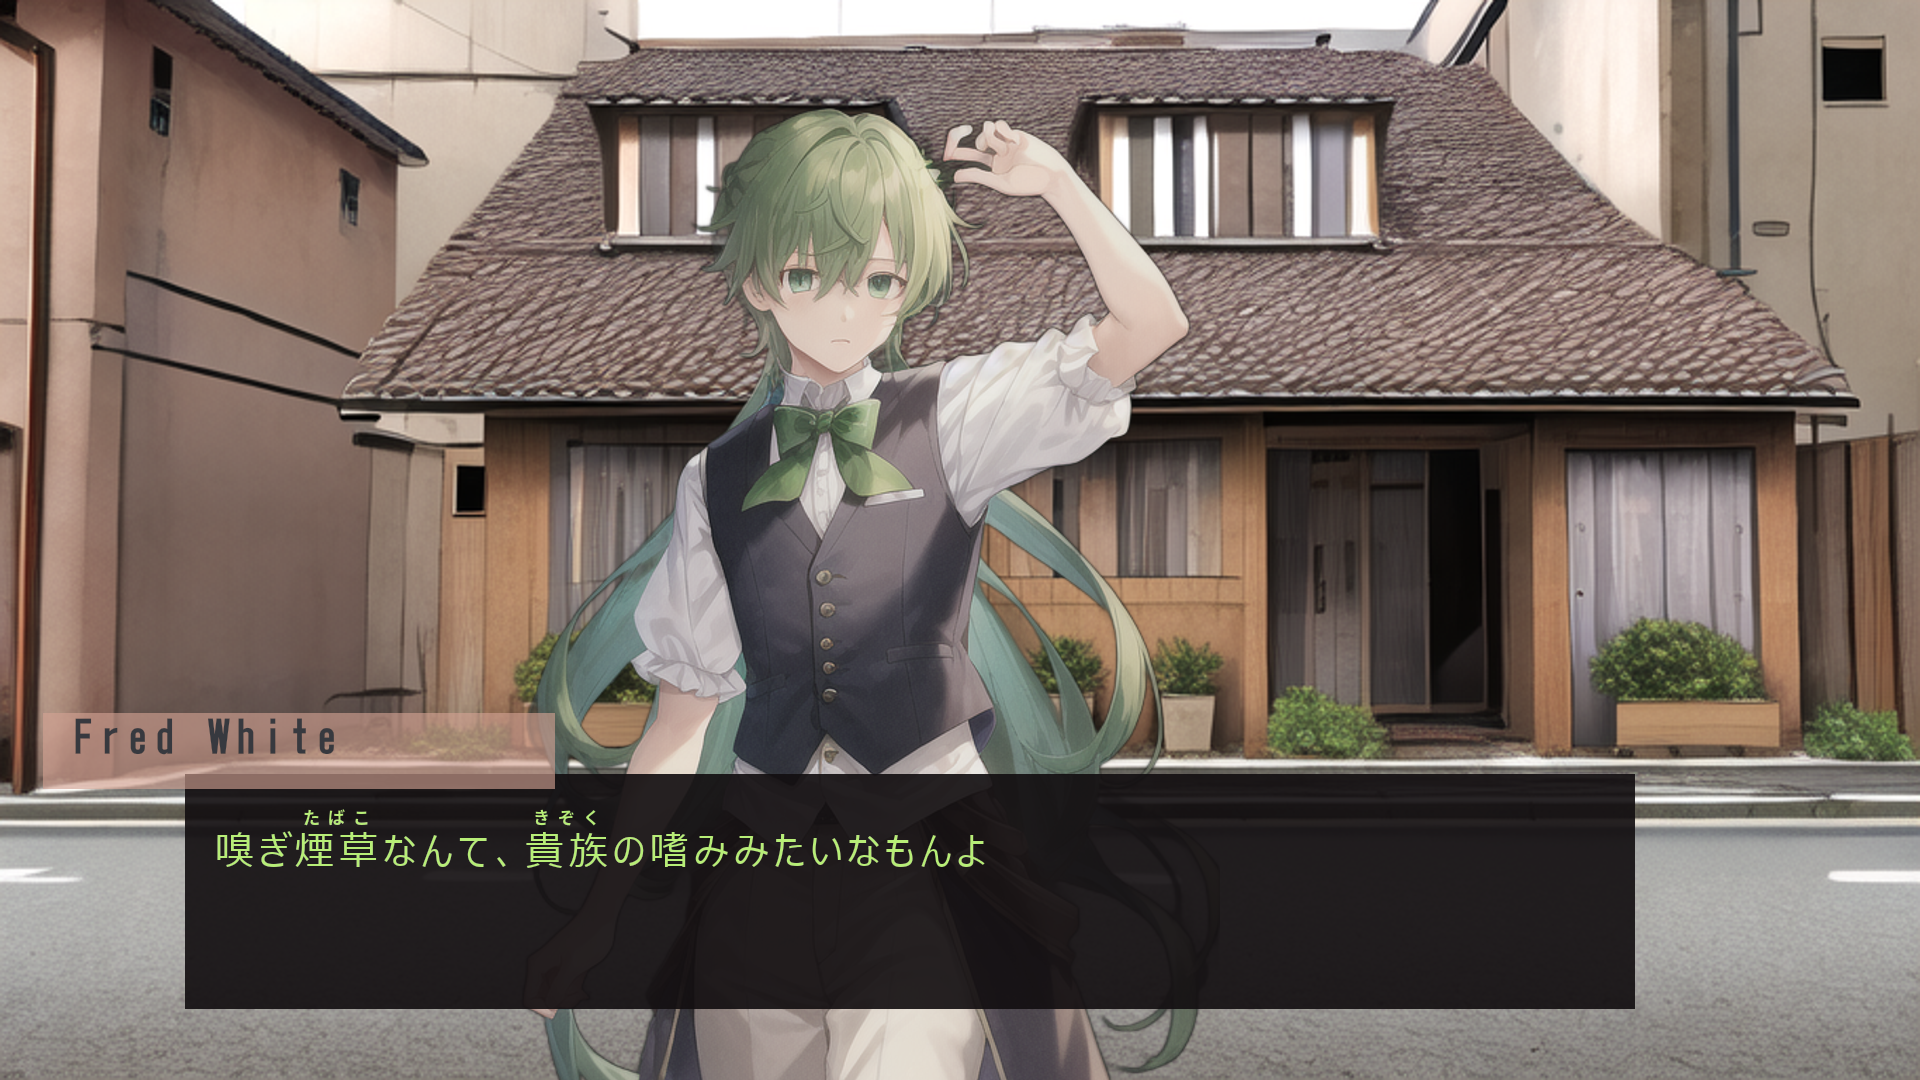

In [14]:
ds[1792]["image"]

In [15]:
json.loads(ds[1792]["ground_truth"])

{'gt_parse': {'messages': ['嗅ぎ<ruby>煙草<rt>たばこ</rt></ruby>なんて、<ruby>貴族<rt>きぞく</rt></ruby>の嗜みみたいなもんよ'],
  'names': ['Fred White'],
  'options': []},
 'meta': {'version': '0.1.0',
  'split': 'train',
  'image_size': {'width': 1920, 'height': 1080}}}